Trabajo Practico de Aprendizaje Automatico <br>
Entrega: 4/03/2024 <br>
Integrante: Mateo Rovere

Actividad 2: <br>
Realizar un análisis descriptivo, que ayude a la comprensión del problema, de cada
una de las variables involucradas en el problema detallando características,
comportamiento y rango de variación

In [1]:
%%capture
!pip install tensorflow optuna shap

Importando todos los modulos

In [2]:
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, stats

# Importaciones de scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin

# Modelos de regresión
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Manejo de desequilibrio de clases
from imblearn.over_sampling import RandomOverSampler

# Modelos y métricas de TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, roc_curve, auc

# Optimización de hiperparámetros con Optuna
import optuna

Obteniendo el csv y haciendo un feature engineering simple

In [3]:
df = pd.read_csv('weatherAUS.csv')
ciudades = ['Albury','Sydney', 'SydneyAirport', 'Canberra','MelbourneAirport', 'Melbourne']
df2 = df[df['Location'].isin(ciudades)]
df2.drop(columns=['Unnamed: 0', 'Date','Location'],inplace=True)
df2['RainToday'] = df2['RainToday'].replace({'Yes': 1, 'No': 0})
df2['RainTomorrow'] = df2['RainTomorrow'].replace({'Yes': 1, 'No': 0})
df2['WindDir3pm'] = df2['WindDir3pm'].str[0]
df2['WindGustDir'] = df2['WindGustDir'].str[0]
df2['WindDir9am'] = df2['WindDir9am'].str[0]
df2.dropna(subset=['Rainfall', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'], inplace=True)
df2

<ipython-input-3-f7cf8abc0558>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(columns=['Unnamed: 0', 'Date','Location'],inplace=True)
<ipython-input-3-f7cf8abc0558>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['RainToday'] = df2['RainToday'].replace({'Yes': 1, 'No': 0})
<ipython-input-3-f7cf8abc0558>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,13.4,22.9,0.6,NaN,NaN,W,44.0,W,W,20.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,0.0
1,7.4,25.1,0.0,NaN,NaN,W,44.0,N,W,4.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,0.0
2,12.9,25.7,0.0,NaN,NaN,W,46.0,W,W,19.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0,0.0
3,9.2,28.0,0.0,NaN,NaN,N,24.0,S,E,11.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0.0,1.0
4,17.5,32.3,1.0,NaN,NaN,W,41.0,E,N,7.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70366,6.4,15.8,0.0,2.4,8.8,N,39.0,N,N,11.0,...,56.0,1028.1,1024.5,1.0,7.0,7.9,15.6,0.0,0.0,0.6
70367,7.8,13.5,0.6,0.6,0.0,N,24.0,W,S,2.0,...,80.0,1028.8,1028.4,7.0,7.0,11.2,12.7,0.0,0.0,0.2
70368,6.7,14.1,0.2,0.6,0.0,N,24.0,N,N,9.0,...,56.0,1028.2,1024.8,7.0,7.0,7.5,13.5,0.0,0.0,0.0
70369,7.4,14.9,0.0,1.6,6.0,N,44.0,N,N,17.0,...,63.0,1018.8,1013.8,1.0,7.0,9.1,12.5,0.0,1.0,1.4


Haciendo algunos train_test_split que me van a ser utiles para mas tarde, los hago ahora para no tener data leakage

In [4]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(df2.drop(["RainTomorrow",'RainfallTomorrow'],axis=1), df2["RainfallTomorrow"], test_size=0.15, random_state=42, shuffle=False)
train_dataset_reg = pd.concat([X_train_reg, y_train_reg], axis=1)
df_reg=train_dataset_reg
df_reg_pipe = df_reg.copy()
test_dataset_reg = pd.concat([X_test_reg, y_test_reg], axis=1)

X_train_cla, X_test_cla, y_train_cla, y_test_cla = train_test_split(df2.drop(["RainTomorrow",'RainfallTomorrow'],axis=1), df2["RainTomorrow"], test_size=0.15, random_state=42, shuffle=False)
train_dataset_cla = pd.concat([X_train_cla, y_train_cla], axis=1)
df_cla=train_dataset_cla
test_dataset_cla = pd.concat([X_test_cla, y_test_cla], axis=1)

#EDA

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18026 entries, 0 to 70370
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MinTemp           18017 non-null  float64
 1   MaxTemp           18020 non-null  float64
 2   Rainfall          18026 non-null  float64
 3   Evaporation       13355 non-null  float64
 4   Sunshine          13105 non-null  float64
 5   WindGustDir       16582 non-null  object 
 6   WindGustSpeed     16584 non-null  float64
 7   WindDir9am        16842 non-null  object 
 8   WindDir3pm        17697 non-null  object 
 9   WindSpeed9am      17765 non-null  float64
 10  WindSpeed3pm      17770 non-null  float64
 11  Humidity9am       17936 non-null  float64
 12  Humidity3pm       17979 non-null  float64
 13  Pressure9am       17774 non-null  float64
 14  Pressure3pm       17778 non-null  float64
 15  Cloud9am          14410 non-null  float64
 16  Cloud3pm          14303 non-null  float6

In [6]:
df2.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
count,18017.000000,18020.000000,18026.000000,13355.000000,13105.000000,16584.000000,17765.000000,17770.000000,17936.000000,17979.000000,17774.000000,17778.000000,14410.000000,14303.000000,18000.000000,18008.000000,18026.000000,18026.000000,18026.000000
mean,11.264728,21.941160,2.237690,4.881041,6.907707,42.252894,15.060118,20.497636,69.746041,50.679737,1018.342011,1016.022151,4.885496,4.802978,15.383039,20.458374,0.228004,0.225064,2.192433
std,5.966638,6.388263,7.227048,3.056038,3.837245,15.310533,10.235984,9.579493,16.083328,18.160965,7.395542,7.242085,2.742710,2.625254,5.732940,6.183585,0.419557,0.417636,7.143983
min,-8.000000,4.100000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,11.000000,3.000000,986.700000,982.900000,0.000000,0.000000,-1.300000,3.700000,0.000000,0.000000,0.000000
25%,7.400000,17.000000,0.000000,2.600000,3.800000,31.000000,7.000000,13.000000,59.000000,38.000000,1013.400000,1011.100000,2.000000,2.000000,11.200000,15.800000,0.000000,0.000000,0.000000
50%,11.300000,21.400000,0.000000,4.200000,7.600000,41.000000,13.000000,20.000000,70.000000,50.000000,1018.500000,1016.150000,6.000000,6.000000,15.300000,19.900000,0.000000,0.000000,0.000000
75%,15.600000,26.200000,0.800000,6.600000,10.000000,52.000000,20.000000,26.000000,81.000000,62.000000,1023.300000,1020.900000,7.000000,7.000000,19.500000,24.600000,0.000000,0.000000,0.600000
max,30.500000,46.800000,119.400000,23.800000,13.900000,122.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,37.200000,46.100000,1.000000,1.000000,119.400000


In [7]:
print(f'Cantidad de registros: {df2.shape[0]}')
print(f'Registros con todos los datos presentes: {df2.notnull().all(axis=1).sum()}')

print('Cantidad de registros faltantes para cada variable')
df2.isna().sum()

Cantidad de registros: 18026
Registros con todos los datos presentes: 10461
Cantidad de registros faltantes para cada variable


MinTemp                9
MaxTemp                6
Rainfall               0
Evaporation         4671
Sunshine            4921
WindGustDir         1444
WindGustSpeed       1442
WindDir9am          1184
WindDir3pm           329
WindSpeed9am         261
WindSpeed3pm         256
Humidity9am           90
Humidity3pm           47
Pressure9am          252
Pressure3pm          248
Cloud9am            3616
Cloud3pm            3723
Temp9am               26
Temp3pm               18
RainToday              0
RainTomorrow           0
RainfallTomorrow       0
dtype: int64

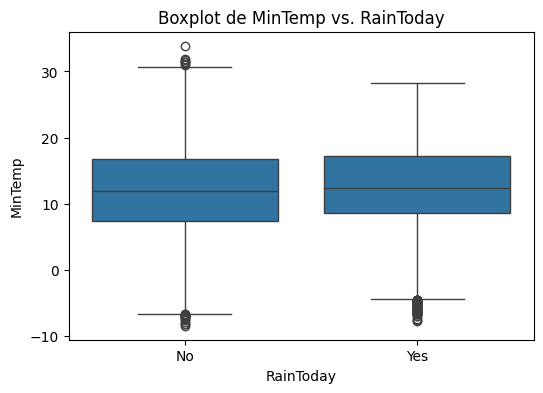

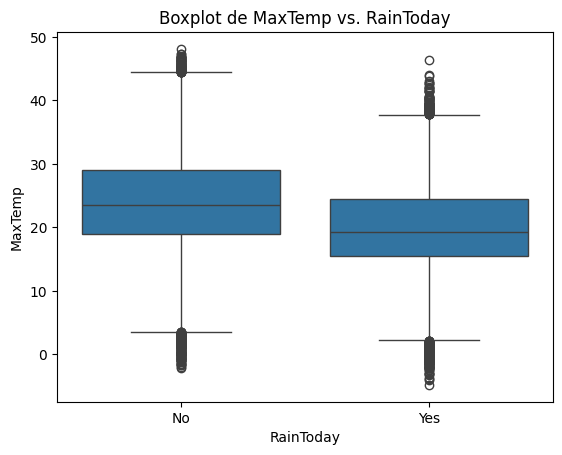

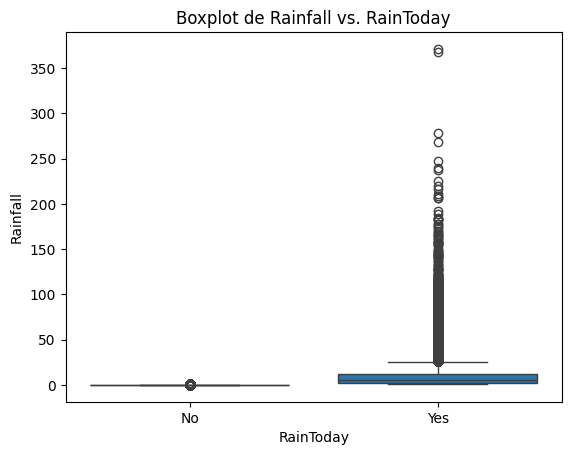

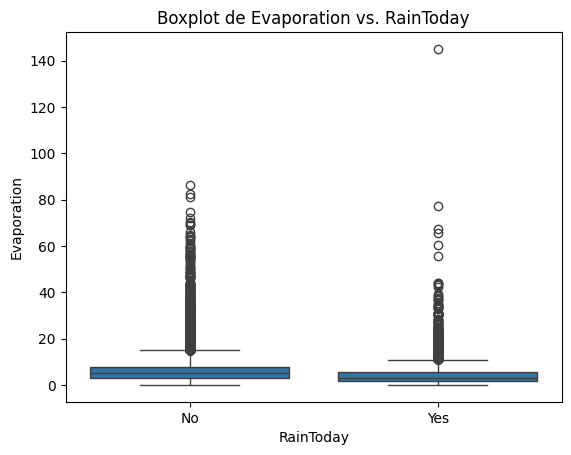

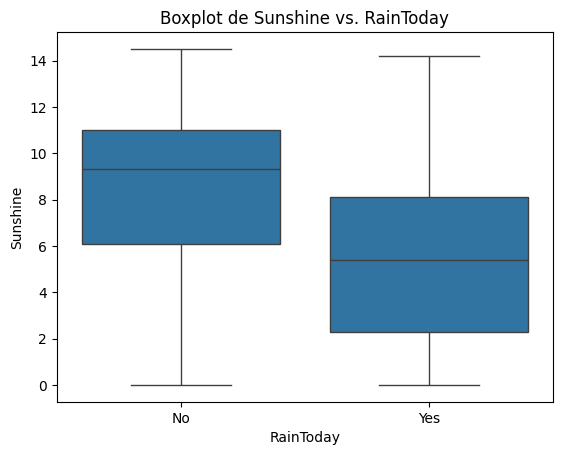

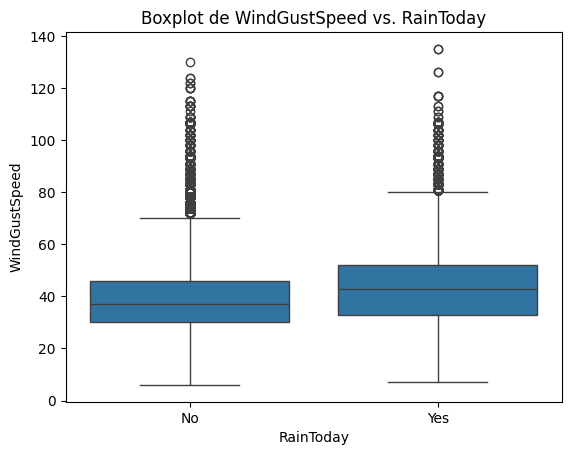

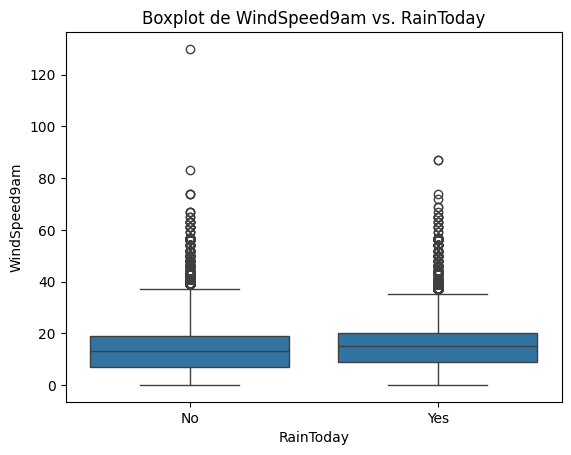

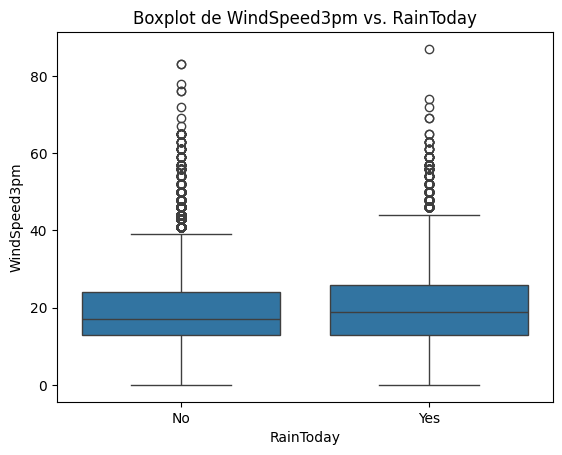

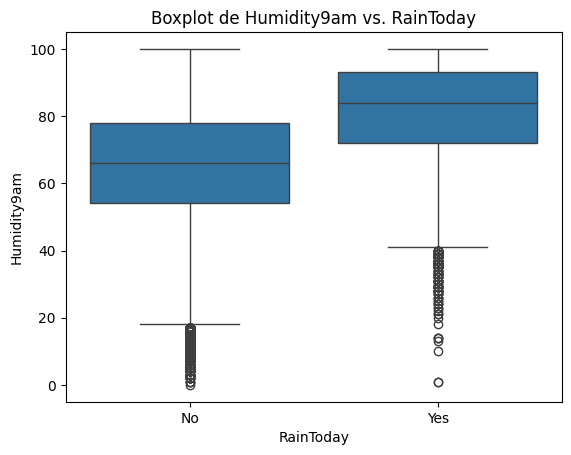

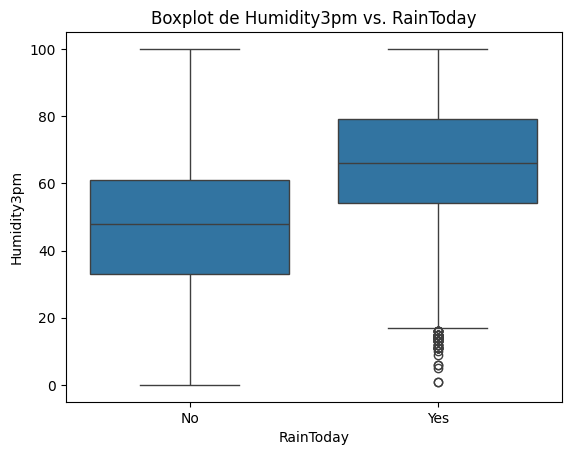

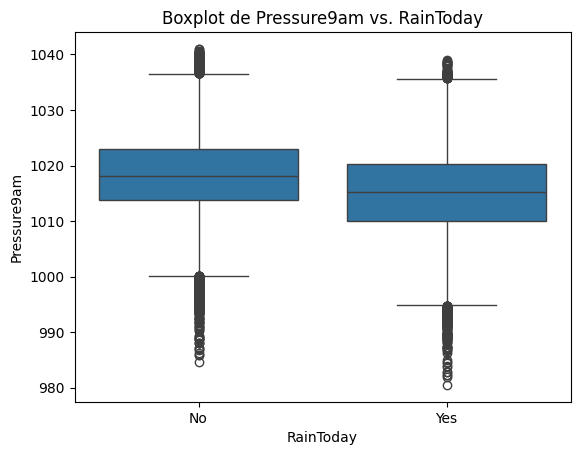

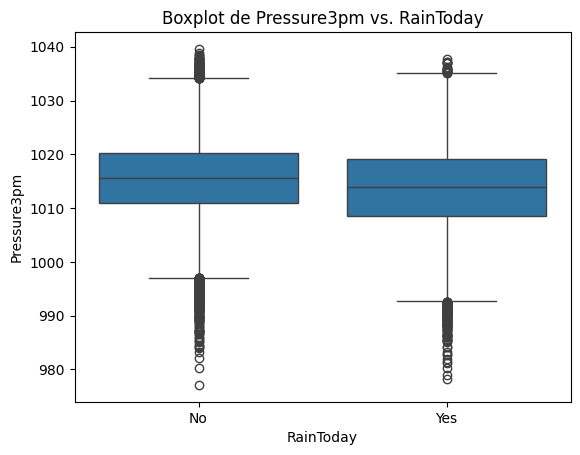

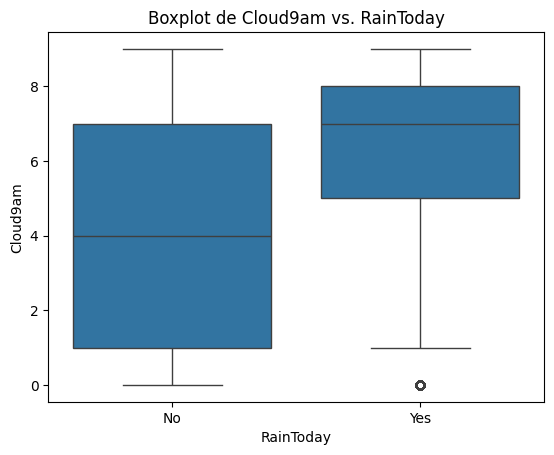

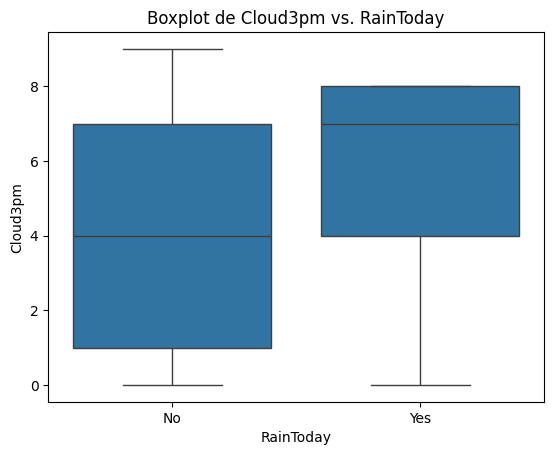

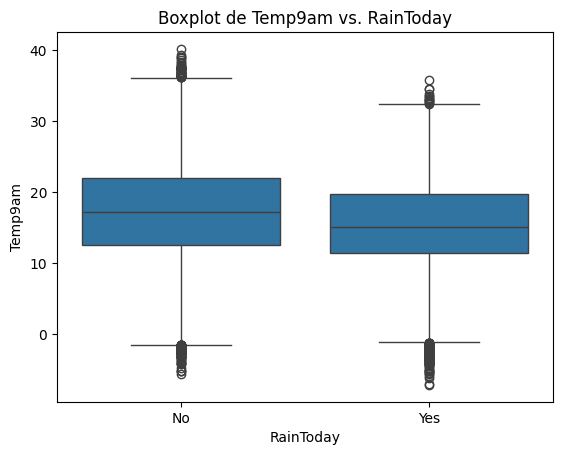

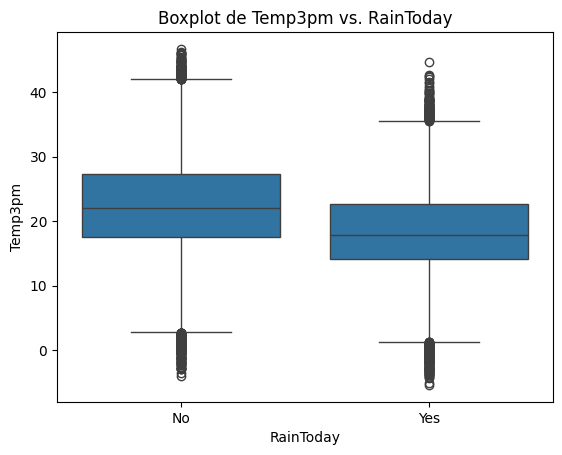

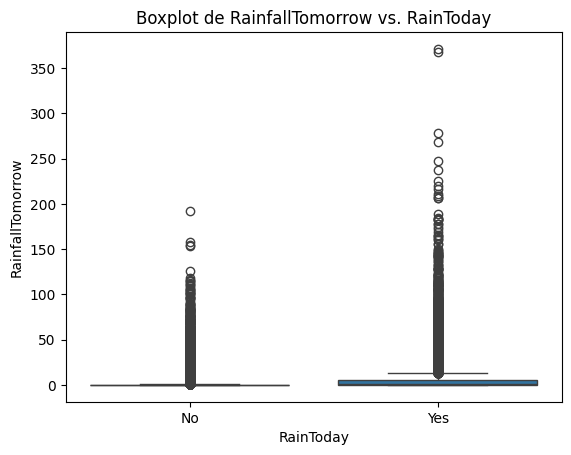

In [8]:
plt.figure(figsize=(6, 4))

for column in df.describe().columns[1:]:
    if column != 'RainToday':
        sns.boxplot(x='RainToday', y=column, data=df)
        plt.title(f'Boxplot de {column} vs. RainToday')
        plt.ylabel(column)
        plt.show()

Con este Grafico podemos ver claramente que tenemos un dataset desbalanceado

Text(0.5, 1.0, 'RainToday Distribution')

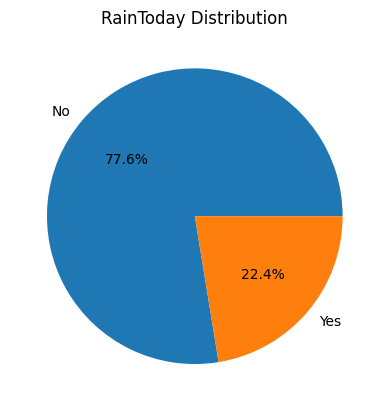

In [9]:
rain_today_counts = df['RainToday'].value_counts()

plt.pie(rain_today_counts, labels=rain_today_counts.index, autopct='%1.1f%%')

plt.title('RainToday Distribution')

#Está desbalanceado, una solución posible es hacer que los pesos en la LogisticRegression sean mayores en el Si que en el No

<ipython-input-10-0e789f47233a>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr().select_dtypes(include=[np.number]).round(2), annot=True)


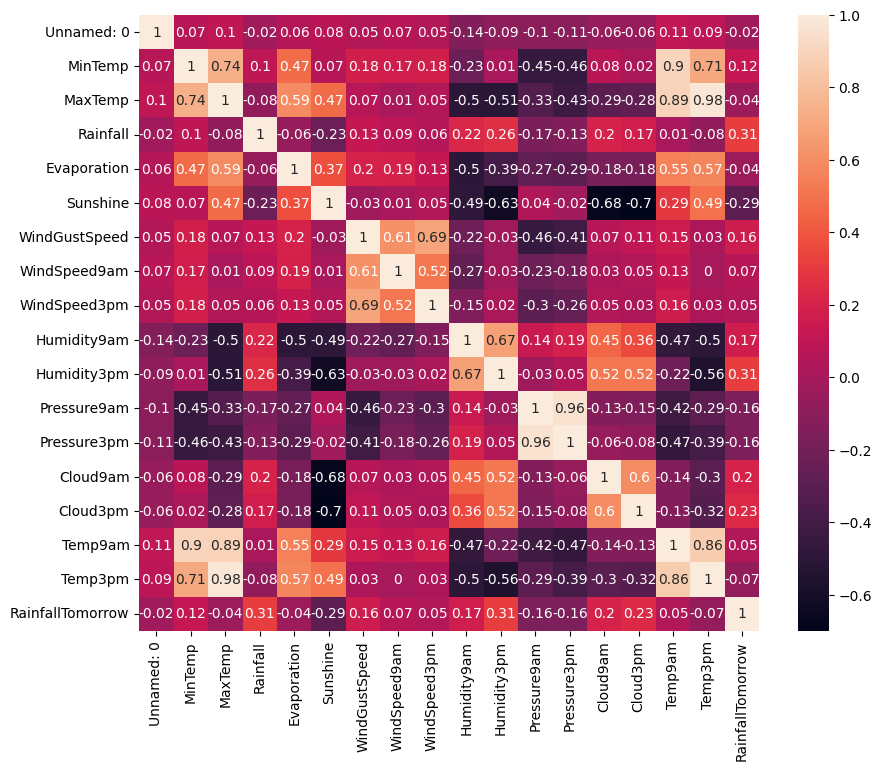

In [10]:
plt.figure(figsize=(10, 8))

sns.heatmap(df.corr().select_dtypes(include=[np.number]).round(2), annot=True)

plt.show()

#Se puede ver un alta correlacion entre: <br>
*Pressure3pm y Pressure9am <br>
*Temp9am y MinTemp <br>
*Temp3pm y MaxTemp <br>
*Temp9am y MaxTemp <br>
Por eso decidi sacar estas columnas: 'Temp9am','Temp3pm','Pressure9am'

In [11]:
df_reg.drop(['Temp9am','Temp3pm','Pressure9am'], axis = 1, inplace=True)
df_reg_pipe.drop(['Temp9am','Temp3pm','Pressure9am'], axis = 1, inplace=True)
X_train_reg.drop(['Temp9am','Temp3pm','Pressure9am'], axis = 1, inplace=True)
X_train_cla.drop(['Temp9am','Temp3pm','Pressure9am'], axis = 1, inplace=True)
test_dataset_reg.drop(['Temp9am','Temp3pm','Pressure9am'], axis = 1, inplace=True)
df_cla.drop(['Temp9am','Temp3pm','Pressure9am'], axis = 1, inplace=True)
test_dataset_cla.drop(['Temp9am','Temp3pm','Pressure9am'], axis = 1, inplace=True)
df_reg_pipe.to_csv("/content/dfmlops.csv", index=False)

In [12]:
# from statistics import mode
# df3 = df2.copy()

# for index, row in df3.iterrows():
#     for col in df3.columns:
#         if pd.isna(row[col]):
#             date = row['Date']
#             ciudad_cercana_data = mode(df3[df3['Date'] == date][col])
#             df3.at[index, col] = ciudad_cercana_data

In [13]:
def numericas_categoricas(df2):
  '''Divide el dataframe en variables numéricas
  y categóricas'''
  numerical = []
  categorical = []
  for columna in df2.columns:
    if df2[columna].dtype in ['float64','int64']:
      numerical.append(columna)
    if df2[columna].dtype == 'object':
      categorical.append(columna)
  return numerical, categorical

In [14]:
numerical, categorical = numericas_categoricas(df2)

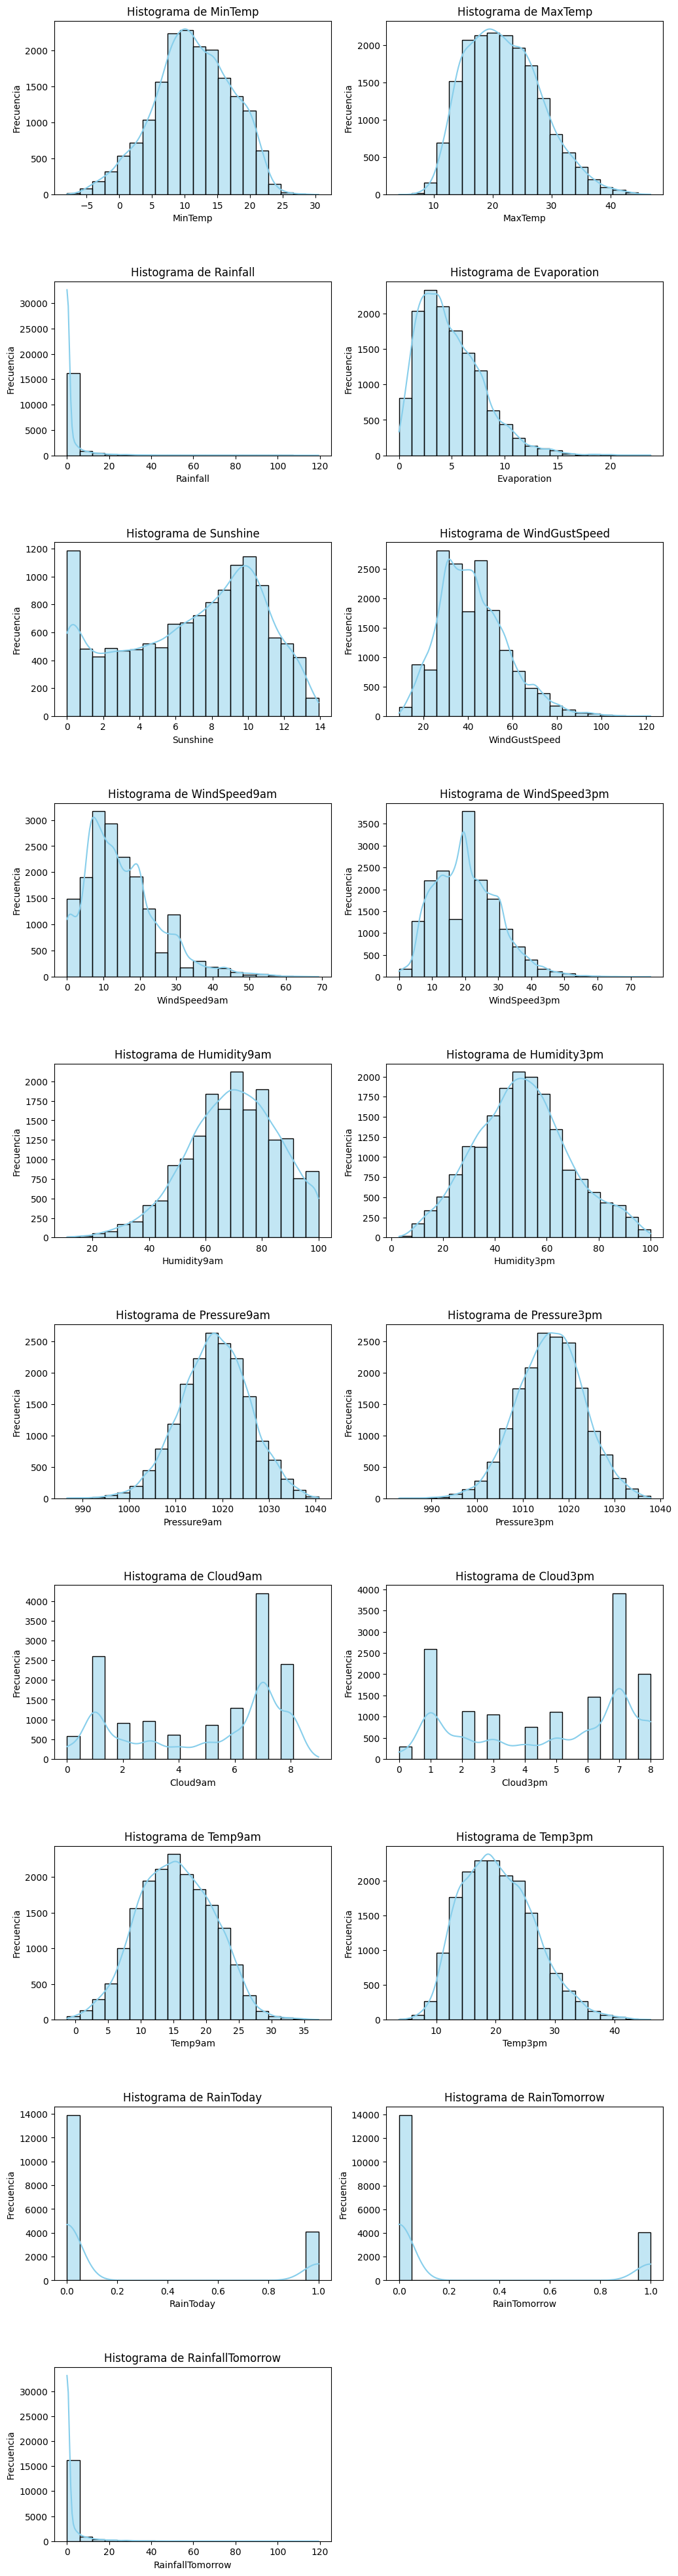

In [15]:
def plot_histogramas(df, numerical):
    num_cols = len(numerical)
    num_rows = (num_cols // 2) + (1 if num_cols % 2 != 0 else 0)

    fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 5))
    fig.subplots_adjust(hspace=0.5)

    for i, column in enumerate(numerical):
        row, col = divmod(i, 2)
        ax = axes[row, col]

        sns.histplot(df[column], bins=20, kde=True, ax=ax, color='skyblue')
        ax.set_title(f'Histograma de {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frecuencia')

    # Eliminar el último subplot si hay un número impar de columnas
    if num_cols % 2 != 0:
        fig.delaxes(axes[num_rows-1, 1])

    plt.show()

# Uso de la función
plot_histogramas(df2, numerical)

<ipython-input-16-0ec0e3a081ad>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, palette="Set3", ax=axes[i])
<ipython-input-16-0ec0e3a081ad>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, palette="Set3", ax=axes[i])
<ipython-input-16-0ec0e3a081ad>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, palette="Set3", ax=axes[i])


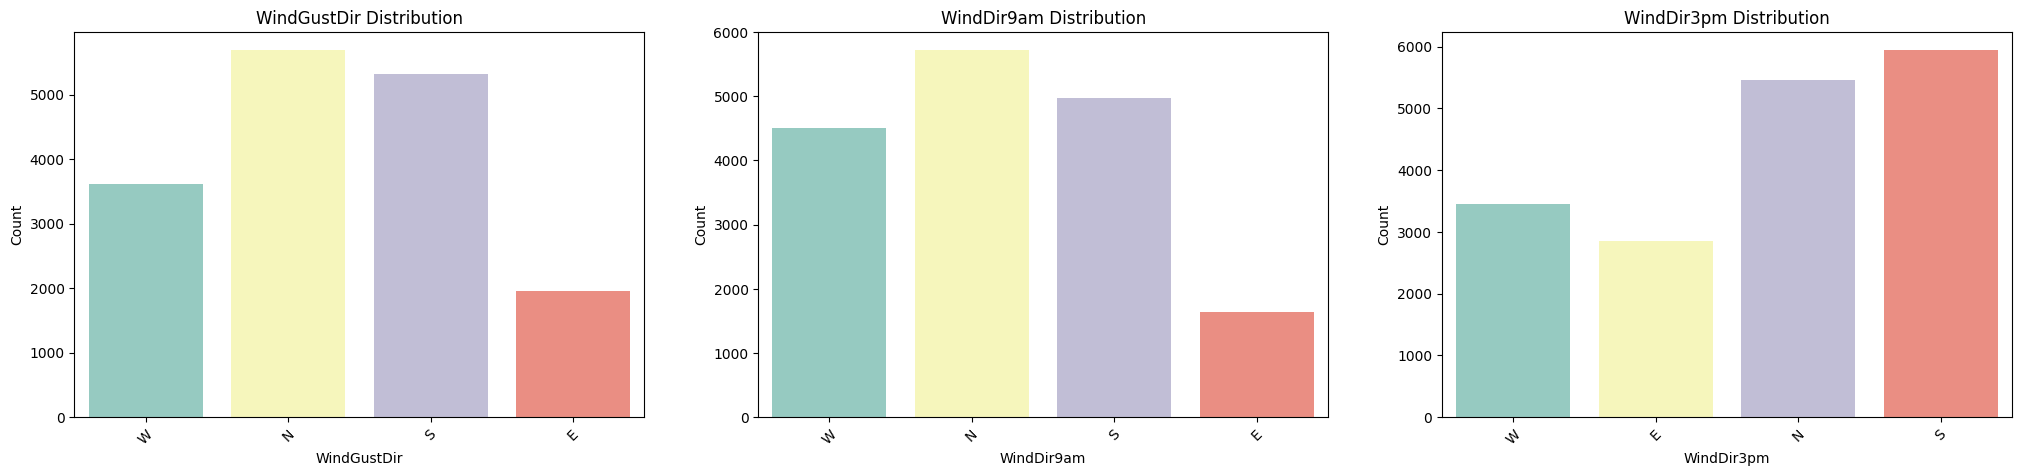

In [16]:
def plot_distribuciones_categoricas(df, categorical):
    '''Recibe un dataframe y sus columnas categóricas y realiza
    un gráfico de distribuciones para cada una de ellas.'''
    num_plots = len(categorical)
    num_rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)

    fig, axes = plt.subplots(num_rows, 3, figsize=(25, num_rows * 5))
    fig.subplots_adjust(hspace=0.5)

    axes = axes.flatten()

    for i, var in enumerate(categorical):
        sns.countplot(data=df, x=var, palette="Set3", ax=axes[i])
        axes[i].set_title(f'{var} Distribution')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)

    # Eliminamos subgráficos vacíos si es necesario
    for j in range(num_plots, num_rows * 3):
        fig.delaxes(axes[j])

    plt.show()

plot_distribuciones_categoricas(df2, categorical)

Imputando y haciendo las dummies

In [17]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

def imputar(df, test_dataset):
    # Imputación por media para las columnas numéricas
    numericas = df.select_dtypes(include=[np.number])
    columnas_numericas = list(numericas.columns)
    num_test = test_dataset.select_dtypes(include=[np.number])
    imputer_num = SimpleImputer(strategy="mean")
    scaler = StandardScaler()
    df_numericas_imputadas = pd.DataFrame(imputer_num.fit_transform(numericas), columns=columnas_numericas)
    test_imputado_num = pd.DataFrame(imputer_num.transform(num_test), columns=columnas_numericas)
    df_num_escaladas = pd.DataFrame(scaler.fit_transform(df_numericas_imputadas), columns=columnas_numericas)
    test_escalado = pd.DataFrame(scaler.transform(test_imputado_num), columns=columnas_numericas)

    # Imputación por moda para las demás columnas
    categoricas = df.select_dtypes(exclude=[np.number])
    columnas_categoricas = list(categoricas.columns)
    cat_test = test_dataset.select_dtypes(exclude=[np.number])
    imputer_cat = SimpleImputer(strategy="most_frequent")
    df_categoricas_imputadas = pd.DataFrame(imputer_cat.fit_transform(categoricas), columns=columnas_categoricas)
    df_cat_imput_dummy = pd.get_dummies(df_categoricas_imputadas, columns=columnas_categoricas)
    test_imputado_cat = pd.DataFrame(imputer_cat.transform(cat_test), columns=columnas_categoricas)
    test_imput_cat_dummies = pd.get_dummies(test_imputado_cat, columns=columnas_categoricas)


    df_imputado = pd.concat([df_num_escaladas, df_cat_imput_dummy], axis=1)
    test_imputado = pd.concat([test_escalado, test_imput_cat_dummies], axis=1)

    return df_imputado, test_imputado

X_train_reg = df_reg.drop(columns=['RainfallTomorrow'])
y_train_reg = df_reg['RainfallTomorrow']

X_test_reg = test_dataset_reg.drop(columns=['RainfallTomorrow'])
y_test_reg = test_dataset_reg['RainfallTomorrow']

X_train_cla = df_cla.drop(columns=['RainTomorrow'])
y_train_cla = df_cla['RainTomorrow']

X_test_cla = test_dataset_cla.drop(columns=['RainTomorrow'])
y_test_cla = test_dataset_cla['RainTomorrow']

X_train_cla, X_test_cla = imputar(X_train_cla,X_test_cla)
X_train_reg, X_test_reg = imputar(X_train_reg,X_test_reg)

In [18]:
X_train_cla.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday',
       'WindGustDir_E', 'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W',
       'WindDir9am_E', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W',
       'WindDir3pm_E', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W'],
      dtype='object')

Actividad 3:

#Linear regression

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

model_reg = LinearRegression()
model_reg.fit(X_train_reg, y_train_reg)


y_pred_reg = model_reg.predict(X_test_reg)

from sklearn.metrics import mean_squared_error, r2_score

mse_rainfall_tomorrow = mean_squared_error(y_test_reg, y_pred_reg)
r2_rainfall_tomorrow = r2_score(y_test_reg, y_pred_reg)


print(f'MSE Rainfall Tomorrow: {mse_rainfall_tomorrow}')
print(f'R^2 Rainfall Tomorrow: {r2_rainfall_tomorrow}')

MSE Rainfall Tomorrow: 17.427332330272055
R^2 Rainfall Tomorrow: 0.08186144307900334


#Descenso del grandiente

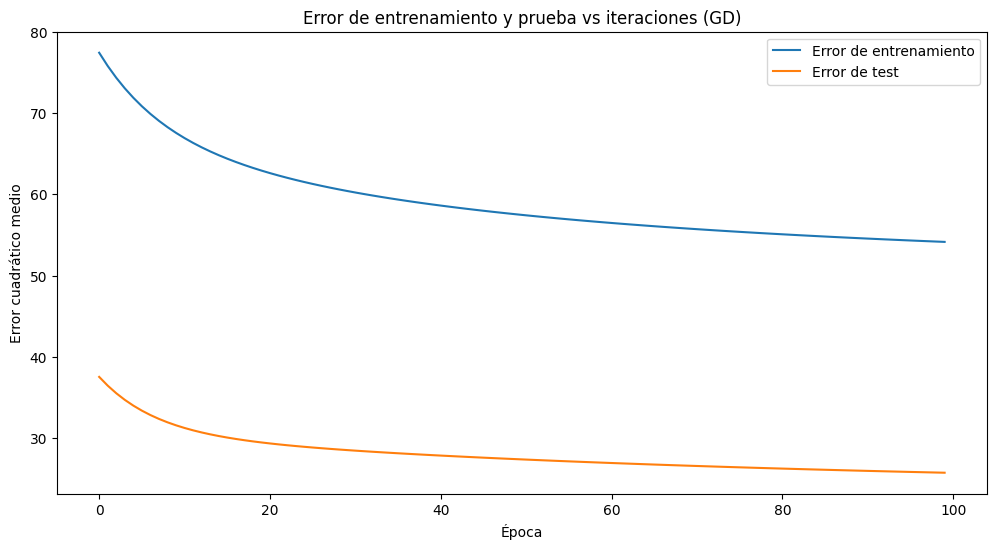

In [20]:
def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))


    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de test')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W
X_train_des, X_test_des, y_train_des, y_test_des = train_test_split(X_train_reg, y_train_reg.values.reshape(-1,1) , random_state=42, shuffle=False)
w = gradient_descent(X_train_des, y_train_des, X_test_des, y_test_des, lr=0.01, epochs=100)

Regularizacion

In [21]:
X = X_train_reg
y = y_train_reg

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV

lassoCV = LassoCV()  # alpha controla la fuerza de la regularización L1 (Lasso)
ridgeCV = RidgeCV()  # alpha controla la fuerza de la regularización L2 (Ridge)
elasticnetCV = ElasticNetCV()

# Ajustar modelos a los datos
lassoCV.fit(X, y)
ridgeCV.fit(X, y)
elasticnetCV.fit(X,y)

#Mostrar alphas
print(lassoCV.alpha_)
print(ridgeCV.alpha_)
print(elasticnetCV.alpha_ )

# Mostrar coeficientes
print("\nCoeficientes del modelo Lasso:")
print(lassoCV.score(X,y))

print("\nCoeficientes del modelo Ridge:")
print(ridgeCV.score(X,y))


print("\nCoeficientes del modelo ElasticNet:")
print(elasticnetCV.score(X,y))

0.01663729802304848
10.0
0.021892462275786537

Coeficientes del modelo Lasso:
0.2322018545336676

Coeficientes del modelo Ridge:
0.23261366877324496

Coeficientes del modelo ElasticNet:
0.23200226949597458


Actividad 4:

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc


logistic_model = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model.fit(X_train_cla, y_train_cla)
y_pred = logistic_model.predict(X_test_cla)

y_probs = logistic_model.predict_proba(X_test_cla)[:, 1]

Curva ROC-AUC

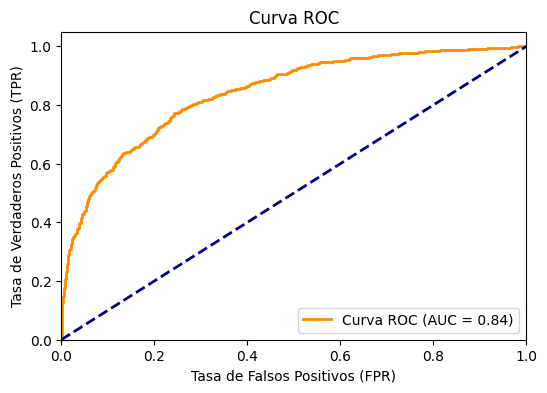

In [23]:
fpr, tpr, thresholds = roc_curve(y_test_cla, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


En esta curva el treshold que mejor funciona es el que este mas cercano al punto (0,1)

In [24]:
accuracy = accuracy_score(y_test_cla, y_pred)
precision = precision_score(y_test_cla, y_pred)
recall = recall_score(y_test_cla, y_pred)
f1 = f1_score(y_test_cla, y_pred)
confusion = confusion_matrix(y_test_cla, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.7511094674556213
Precision: 0.4825918762088975
Recall: 0.783359497645212
F1 Score: 0.5972471573907839
Confusion Matrix:
[[1532  535]
 [ 138  499]]


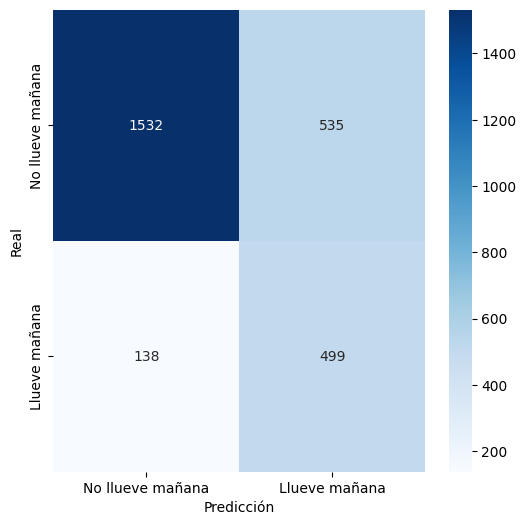

In [25]:
class_labels = ["No llueve mañana", "Llueve mañana"]

plt.figure(figsize=(6, 6))

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicción')
plt.ylabel('Real')

plt.show()


Actividad 5: <br>
Para hacer un modelo base de la variable objetivo continua, optamos por tomar la mediana de la catidad de lluvia del dia actual


In [26]:
mediana = X_train_reg['Rainfall'].median()
mediana

-0.3068880859775954

In [27]:
mse_rainfall_tomorrow = mean_squared_error(y_train_reg, np.array([mediana] * len(y_train_reg)))
print("mse:",mse_rainfall_tomorrow)

mse: 63.432039652231886


Para hacer un modelo base de la variable objetivo binaria, dado que es una clase desbalanceada conviene basarse en la mayoría.
En este caso, decir siempre que no va a llover tiene una precisión de casi un 80%. Siendo 0 que no llueve

In [28]:
valor_mas_comun = y_train_cla.value_counts().idxmax()
valores = np.array([valor_mas_comun] * len(y_test_cla))

In [29]:
accuracy = accuracy_score(y_test_cla, valores)
precision = precision_score(y_test_cla, valores)
recall = recall_score(y_test_cla, valores)
f1 = f1_score(y_test_cla, valores)
confusion = confusion_matrix(y_test_cla, valores)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.7644230769230769
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Confusion Matrix:
[[2067    0]
 [ 637    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Actividad 6:

In [30]:
!pip install keras

Red neuronal para clasificar si llueve o no llueve mañana

In [32]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train_cla, y_train_cla)

X_train_resampled, X_valid_resampled, y_train_resampled, y_valid_resampled = train_test_split(X_resampled,y_resampled,test_size=0.15, shuffle=False)


model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(26,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision()])

model.fit(X_resampled, y_resampled, epochs=100, batch_size=32, validation_data=(X_valid_resampled, y_valid_resampled))

loss, precision = model.evaluate(X_test_cla, y_test_cla)
print(f'Pérdida test: {loss}')
print(f'Exactitud test: {precision}')



Epoch 1/100
214/214 [==============================] - 9s 21ms/step - loss: 0.4798 - precision: 0.7739 - val_loss: 0.4433 - val_precision: 1.0000
Epoch 2/100
214/214 [==============================] - 3s 13ms/step - loss: 0.4396 - precision: 0.7985 - val_loss: 0.3835 - val_precision: 1.0000
Epoch 3/100
214/214 [==============================] - 2s 9ms/step - loss: 0.4233 - precision: 0.8051 - val_loss: 0.5183 - val_precision: 1.0000
Epoch 4/100
214/214 [==============================] - 2s 9ms/step - loss: 0.4140 - precision: 0.8123 - val_loss: 0.4175 - val_precision: 1.0000
Epoch 5/100
214/214 [==============================] - 2s 7ms/step - loss: 0.4013 - precision: 0.8145 - val_loss: 0.3958 - val_precision: 1.0000
Epoch 6/100
214/214 [==============================] - 1s 6ms/step - loss: 0.3941 - precision: 0.8197 - val_loss: 0.3899 - val_precision: 1.0000
Epoch 7/100
214/214 [==============================] - 2s 8ms/step - loss: 0.3803 - precision: 0.8285 - val_loss: 0.3475 - val_p

85/85 [==============================] - 0s 2ms/step


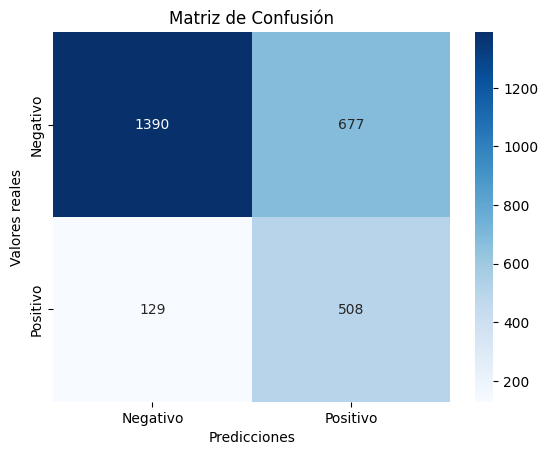

In [33]:
y_pred_prob = model.predict(X_test_cla)
y_pred = (y_pred_prob >= 0.5).astype(int)
confusion = confusion_matrix(y_test_cla, y_pred)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de Confusión')
plt.show()

#SHAP para red neuronal

In [34]:
import shap
feature_names=X_train_reg.columns.values
feature_names

array(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday',
       'WindGustDir_E', 'WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W',
       'WindDir9am_E', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W',
       'WindDir3pm_E', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W'],
      dtype=object)

In [35]:
K = 1

background_summary = shap.kmeans(X_resampled, K)  # O shap.kmeans(X_resampled, K)

explainer = shap.KernelExplainer(model.predict, background_summary)

shap_values = explainer.shap_values(X_test_cla, nsamples=100)


1/1 [==============================] - 0s 70ms/step


  0%|          | 0/2704 [00:00<?, ?it/s]

Se truncaron las últimas líneas 5000 del resultado de transmisión.
4/4 [==============================] - 0s 4ms/step


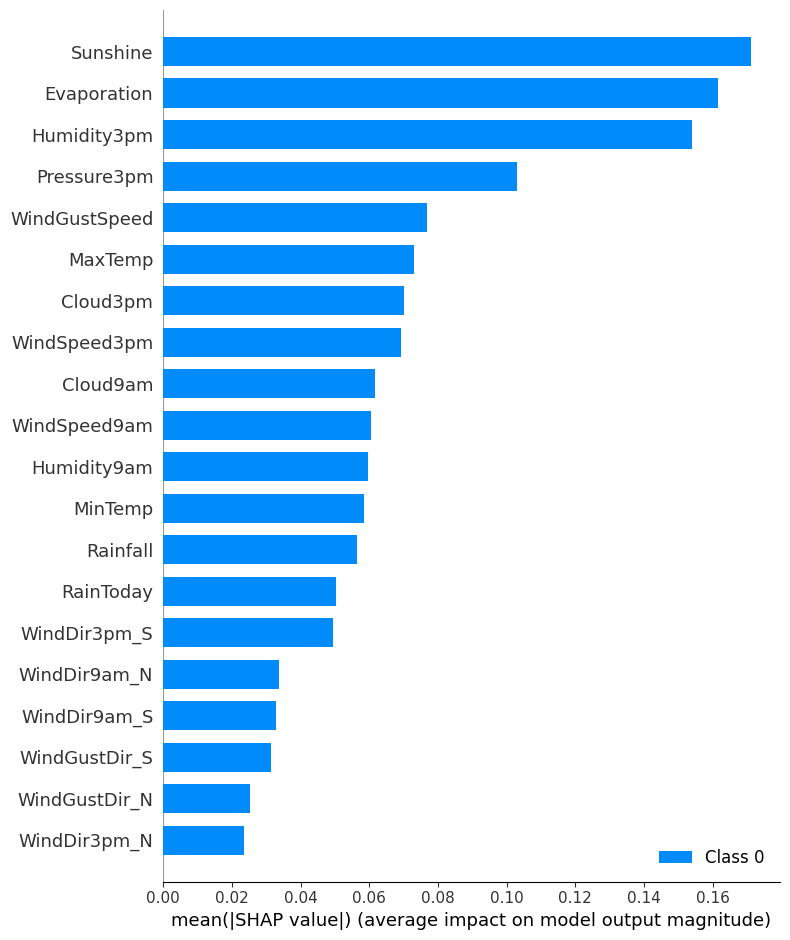

In [36]:
shap.summary_plot(shap_values,X_test_cla,feature_names=feature_names)

In [37]:
index = 0
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)
explanation

.values =
array([[-0.17139878, -0.06640648,  0.        , ..., -0.10025526,
         0.        ,  0.        ],
       [-0.01858367, -0.12133167, -0.12086767, ...,  0.        ,
         0.        , -0.05598624],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.07218855, -0.18093303,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.15733086,  0.15744855, -0.13621309, ...,  0.02038831,
         0.        ,  0.        ],
       [-0.08991831, -0.17106552,  0.06481924, ...,  0.        ,
         0.        ,  0.        ]])

.base_values =
array([0.99412662])

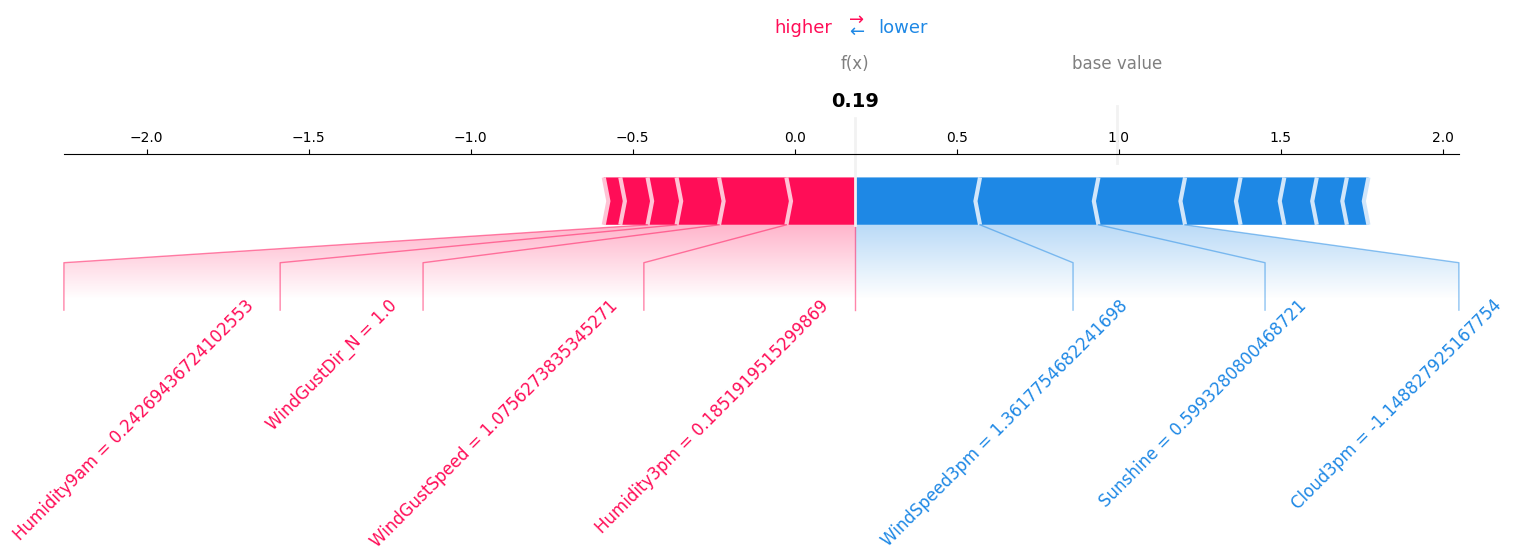

In [38]:
shap.force_plot(explainer.expected_value, explanation.values[0, :], X_test_cla.iloc[index, :], feature_names=feature_names, matplotlib=True, figsize=(18, 4), text_rotation=45)

#Shap para regresión lineal

In [ ]:
# import shap

# explainer = shap.LinearExplainer(model_reg, X_train_reg, feature_names=feature_names)

# shap_values = explainer.shap_values(X_test_cla)

In [ ]:
# shap.force_plot(explainer.expected_value, explanation.values, X_test_scaled_reg[index], feature_names=feature_names, matplotlib=True, figsize=(18, 4), \
#                 text_rotation=45)

#Red neuronal para regresion

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                1728      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3841 (15.00 KB)
Trainable params: 3841 (15.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
384/384 

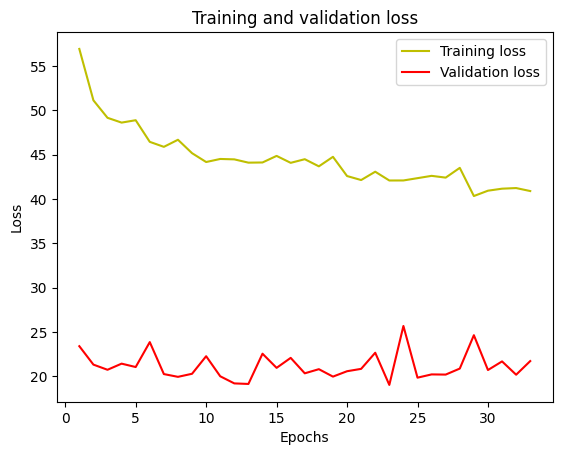

85/85 [==============================] - 0s 1ms/step
Mean Absolute Error: 2.148170407358888
Mean Squared Error: 16.927574615682527
Root Mean Squared Error: 4.114313383261237
R2: 0.10819059192333491


You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


In [39]:
from keras import regularizers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping


# Crear el modelo
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(26,), kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dropout(0.5))
model2.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='linear'))

# Compilar el modelo
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Resumen del modelo
model2.summary()

# Entrenar el modelo con EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model2.fit(X_train_reg, y_train_reg , validation_split=0.2, epochs =100, callbacks=[early_stop])

# Graficar la pérdida de entrenamiento y validación
from matplotlib import pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predecir en el conjunto de prueba
y_pred = model2.predict(X_test_reg)

# Calcular el error absoluto medio, el error cuadrado medio y la raíz del error cuadrado medio
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test_reg, y_pred)
mse = mean_squared_error(y_test_reg, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2: {r2}')


model2.save('reg_nn_model.h5')

#Buscando con optuna los hiperparametros optimos

In [40]:
import optuna
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Assuming y_train_cla and y_valid_cla are not one-hot encoded

X_train, X_valid, y_train, y_valid = train_test_split(X_train_cla, y_train_cla, test_size=0.2, random_state=42, shuffle=False)

def objective(trial):

    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

    model = Sequential()

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128)
        model.add(Dense(num_units, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Define a ModelCheckpoint callback to save the best model
    checkpoint_path = 'best_model_optuna_cla.h5'
    checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')

    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5, batch_size=32, callbacks=[checkpoint_callback], verbose=0)

    score = model.evaluate(X_valid, y_valid, verbose=0)
    return score[1]

# create an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# get the best parameters
best_params = study.best_params
print("Best parameters found:", best_params)

# Load the best model
best_model = Sequential()
best_model.add(Dense(best_params['n_units_layer_0'], activation='relu', input_dim=X_train.shape[1]))

for i in range(1, best_params['num_layers']):
    best_model.add(Dense(best_params[f'n_units_layer_{i}'], activation='relu'))

best_model.add(Dense(1, activation='sigmoid'))
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='binary_crossentropy', metrics=[Precision()])


[I 2024-03-04 21:22:26,325] A new study created in memory with name: no-name-9b0dd6ed-af4d-4b51-babd-cf7ebfe34460
You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
[I 2024-03-04 21:22:38,356] Trial 0 finished with value: 0.8323001861572266 and parameters: {'num_layers': 2, 'learning_rate': 0.0003289082463494777, 'n_units_layer_0': 84, 'n_units_layer_1': 41}. Best is trial 0 with value: 0.8323001861572266.
You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
[I 2024-03-04 21:22:47,495] Trial 1 finished with value: 0.7817292213439941 and parameters: {'num_layers': 2, 'learning_rate': 3.0294563979247538e-05, 'n_units_layer_0': 73, 'n_units_layer_1': 11}. Best is trial 0 with value: 0.8323001861572266.
You are saving 

Best parameters found: {'num_layers': 3, 'learning_rate': 0.006458871667058932, 'n_units_layer_0': 39, 'n_units_layer_1': 68, 'n_units_layer_2': 70}


Para un red neuronal de clasificacion podemos ver que los best_params son: <br>
*Best parameters found: {'num_layers': 2, 'learning_rate': 0.0008741416832822498, 'n_units_layer_0': 75, 'n_units_layer_1': 99}

#Encontrando hiperparametros para una regresion logistica

In [41]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import pickle

model = LogisticRegression(class_weight='balanced')

# Definir los hiperparámetros que deseas ajustar
param_grid = {
    'penalty': [ 'l2'],            # Tipo de penalización
    'C': np.logspace(-4, 4, 10),        # Parámetro de regularización
    'fit_intercept': [True, False],      # Incluir intercepto
    'solver': ['liblinear', 'lbfgs'],   # Algoritmo de optimización
    'max_iter': [60, 100],          # Número máximo de iteraciones
}

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='precision')

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train_cla, y_train_cla)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test_cla)

# Calcular y mostrar métricas adicionales
accuracy = best_model.score(X_test_cla, y_test_cla)
print("Precisión en el conjunto de prueba:", accuracy)

# Otras métricas
print("\nOtras métricas:")
print(classification_report(y_test_cla, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test_cla, y_pred)
print("\nMatriz de confusión:")
print(conf_matrix)

file_name = 'log_reg_cla.pkl'
with open(file_name, 'wb') as file:
  pickle.dump(best_model, file)

Mejores hiperparámetros: {'C': 0.005994842503189409, 'fit_intercept': True, 'max_iter': 60, 'penalty': 'l2', 'solver': 'lbfgs'}
Precisión en el conjunto de prueba: 0.7429733727810651

Otras métricas:
              precision    recall  f1-score   support

         0.0       0.92      0.73      0.81      2067
         1.0       0.47      0.80      0.59       637

    accuracy                           0.74      2704
   macro avg       0.70      0.76      0.70      2704
weighted avg       0.82      0.74      0.76      2704


Matriz de confusión:
[[1501  566]
 [ 129  508]]


Probando si funciona la red neuronal con optuna:

In [42]:
from keras.models import load_model
model = load_model('best_model_optuna_cla.h5')
y_pred_probabilities = model.predict(X_test_cla)

# Convertir probabilidades a etiquetas de clase (usando umbral de decisión 0.5 para clasificación binaria)
y_pred_labels = (y_pred_probabilities > 0.5).astype(int)

# Comparar con etiquetas reales
accuracy = accuracy_score(y_test_cla, y_pred_labels)
print(f'Accuracy on test set: {accuracy * 100:.2f}%')

# Otras métricas de evaluación
print(f'Confusion Matrix:\n{confusion_matrix(y_test_cla, y_pred_labels)}')
print(f'Classification Report:\n{classification_report(y_test_cla, y_pred_labels)}')

85/85 [==============================] - 1s 5ms/step
Accuracy on test set: 81.29%
Confusion Matrix:
[[1941  126]
 [ 380  257]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.94      0.88      2067
         1.0       0.67      0.40      0.50       637

    accuracy                           0.81      2704
   macro avg       0.75      0.67      0.69      2704
weighted avg       0.80      0.81      0.79      2704



In [ ]:
df_reg_pipe = df_reg_pipe[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday','WindGustDir', 'WindDir9am', 'WindDir3pm']]

In [ ]:
df_reg_pipe

#Pipeline
(al final no fue utilizado este)

In [ ]:
numeric_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday']

# Lista de columnas categóricas
categorical_features = ['WindGustDir', 'WindDir9am', 'WindDir3pm']

hiperparametros = {
    'C': 0.005994842503189409,
    'fit_intercept': True,
    'max_iter': 60,
    'penalty': 'l2',
    'solver': 'lbfgs'

}# Crear el preprocesador para las columnas numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Puedes personalizar la estrategia de imputación
    ('scaler', StandardScaler())
])

# Crear el preprocesador para las columnas categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),  # Puedes personalizar la estrategia de imputación
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Crear el ColumnTransformer que combina ambos preprocesadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear el pipeline final que combina el preprocesador con cualquier modelo que desees entrenar
# Aquí, 'model' es el modelo que elijas (por ejemplo, un clasificador o regresor de scikit-learn)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', LogisticRegression(**hiperparametros))])



In [ ]:
df_pipeado = pipeline.fit(df_reg_pipe,y_train_cla)


In [ ]:
import joblib
joblib.dump(pipeline, '/content/mi_pipeline3.pkl')

#Comparacion
Para modelos de Regresion:<br>
Regresion Linear: R2: 0.0818 y MSE: 17.427<br>
Dummy Model: MSE: 63.43<br>
Red Neuronal p/ Regresion:R2: 0.108 y MSE: 16.927<br>

Para modelos de Clasificacion:<br>
Regresion Logistica: Precision: 0.48 y Recall: 0.78<br>
Dummy Model: Precicion y Recall: 0.0<br>
Red Neuronal p/ Clasificacion: Precision: 0.43<br>
Optuna: Precision: 0.67 <br>
Regresion Logistica c/Hiperparametros:  Precision: 0.47<br>

#Conclucion:

Podemos ver como para regresion el mejor modelo es la red neuronal dado que tiene mejor R2 y MSE. <br>
Y para clasificacion la red neuronal con Optuna es la que mejor funciona con estos datos, luego laregresion logistica funciona mejor que la red neuronal sin optuna, y para las dummy models la precicion da 0